In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import math

In [146]:
bbox_df = pd.read_csv('files/bbox_light.csv')

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# dropping rows with all 0
bbox_df = bbox_df[(bbox_df.iloc[:, 1:] == 0).all(axis=1) == False].dropna()

# re-indexing "frame" column and indices
#bbox_df.iloc[:, 0] = np.arange(0, bbox_df.shape[0])
bbox_df = bbox_df.set_index(np.arange(0, bbox_df.shape[0]))

In [348]:
# 2d rotation matrix, used in rotation pipeline suggested by GPT
def R(theta):
    return [[math.cos(theta), -math.sin(theta)], 
            [math.sin(theta), math.cos(theta)]]

# wrapping angle to [-pi, pi)
def wrap(theta):
    return np.arctan2(np.sin(theta), np.cos(theta))

In [ ]:
tl_indices, x_pos, y_pos, forward_motion = [], [], [], []
stable_index, drift_0 = 0, 0
prev_x = prev_y = prev_drift = prev_T = None
R_acc = np.eye(2)
T = np.zeros((2, 1))
T_x, T_y = [0.0], [0.0]

for frame in bbox_df['frame']:

    # obtain horizontal and vertical position values (in pixels) of traffic light
    
    x_min, y_min, x_max, y_max = bbox_df.iloc[stable_index, 1:]
    u = int((x_max + x_min) / 2)
    v = int((y_max + y_min) / 2)
    tl_indices.append([u, v])

    # create formatted depth number for npz file name
    depth_num_formatted = ''
    counter = 100000

    while counter > frame and counter >= 10:
        depth_num_formatted += '0'
        counter /= 10
    
    depth_num_formatted += str(frame)
    
    # find relative position of traffic light using depth map
    depth_frame = np.load(f'files/xyz/depth{depth_num_formatted}.npz')['xyz']
    x, y, z = depth_frame[v, u][0:3]
    if np.isfinite(np.array([x, y, z])).all():
        x_pos.append(x)
        y_pos.append(y)
    else:
        continue

    # --------------------- minimal rotation pipeline ---------------------
    curr_drift = math.atan2(y, x)

    # initial values
    if stable_index == 0:

        R0 = R(math.pi/2 - curr_drift)

        p0 = np.array([[x],[y]], float)
        T  = -np.dot(R0, p0) 
        R_acc = np.eye(2, dtype=float)

        prev_x, prev_y, prev_drift = x, y, curr_drift
        T_x, T_y = [float(T[0,0])], [float(T[1,0])]

        stable_index += 1
        continue

    # first calculating change in orientation between frames

    # calculating drift change
    drift_change_base = wrap(curr_drift - prev_drift)
    drift_change = -(drift_change_base)


    # stabilizing forward motion (GPT)
    s_rot = prev_x - (np.dot(R(drift_change), [[x], [y]]))[0][0]
    s_naive = max(0, prev_x - x)

    r = math.sqrt(x**2 + y**2)
    prev_r = math.sqrt(prev_x**2 + prev_y**2)
    s_rad = max(0, prev_r - r)

    s = np.median([s_rot, s_naive, s_rad])

    forward_motion.append(s)

    # then accounting for drift from actual rotation
    T += np.dot(R_acc, np.array([[0.0], [s]], float))
    R_acc = np.dot(R_acc, R(drift_change))

    # re-scaled and re-positioned x and y since at somepoint their scale and rotation got messed up
    T_x.append(T[0,0]/4.4)
    T_y.append(T[1,0]/4.4 + 9)

    prev_x, prev_y, prev_drift = x, y, curr_drift
    stable_index += 1

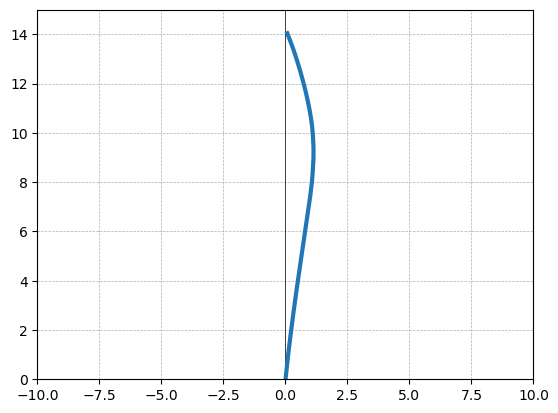

In [456]:
# rotated points
points = np.array([T_x, T_y])
rotated_points = R(np.radians(-6)) @ points

x_rot, y_rot = rotated_points[0, :], rotated_points[1, :]

fig, ax = plt.subplots()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
plt.plot(x_rot, y_rot, linewidth=3.0)
plt.xlim(-10, 10)
plt.ylim(0, 15)
plt.show()